In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, f1_score, average_precision_score
sns.set_theme()

In [2]:
vehicle_df = pd.read_csv('/Users/emilychen/Downloads/csv/vehpub.csv')

In [3]:
vehicle_df.head()

,HOUSEID,VEHID,VEHYEAR,VEHAGE,MAKE,MODEL,FUELTYPE,VEHTYPE,WHOMAIN,OD_READ,...,HTEEMPDN,HBHTNRNT,HBPPOPDN,HBRESDN,GSYRGAL,GSTOTCST,FEGEMPG,FEGEMPGA,GSCOST,FEGEMPGF
0,30000007,1,2007,10,49,49032,1,1,3,69000,...,750,20,750,300,487.064221,1126.457778,30,-9,2.31275,1
1,30000007,2,2004,13,49,49442,1,2,-8,164000,...,750,20,750,300,250.899523,580.267873,19,-9,2.31275,1
2,30000007,3,1998,19,19,19014,1,1,1,120000,...,750,20,750,300,444.462475,1027.930589,18,-9,2.31275,1
3,30000007,4,1997,20,19,19021,1,1,2,-88,...,750,20,750,300,40.329575,93.272224,18,-9,2.31275,1
4,30000007,5,1993,24,20,20481,1,4,2,300000,...,750,20,750,300,888.404197,2054.656806,14,-9,2.31275,1


## Multinomial Logit Model

Vehicle Type and Household Family Income are unbalanced variables. Metrics, such as accuracy may not be the best. First, test on AUC/ROC curve. Then, P/R curve that is sensitive to imbalance.

In [46]:
# model with features: population density, household size, fuel type to predict vehicle type
filtered_vehicle = vehicle_df[(vehicle_df['VEHTYPE']> 0) & (vehicle_df['VEHTYPE'] != 97) & (vehicle_df['HTPPOPDN'] > 0)& (vehicle_df['HHFAMINC'] > 0)]
X = filtered_vehicle[['HTPPOPDN', 'HHFAMINC']]
y = filtered_vehicle['VEHTYPE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [34]:
model = LogisticRegression(class_weight='balanced', multi_class='multinomial', solver='lbfgs', max_iter=1500)
model.fit(X_train, y_train)
predictions = model.predict_proba(X_test)

/Users/emilychen/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/emilychen/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/emilychen/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/emilychen/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future

Class 1 AUC: 0.5773341414560795
Class 2 AUC: 0.5102056382097324
Class 3 AUC: 0.5108259066799018
Class 4 AUC: 0.5982976916638489
Class 5 AUC: 0.5976561591008984
Class 6 AUC: 0.5881977487383666
Class 7 AUC: 0.5280480672967043


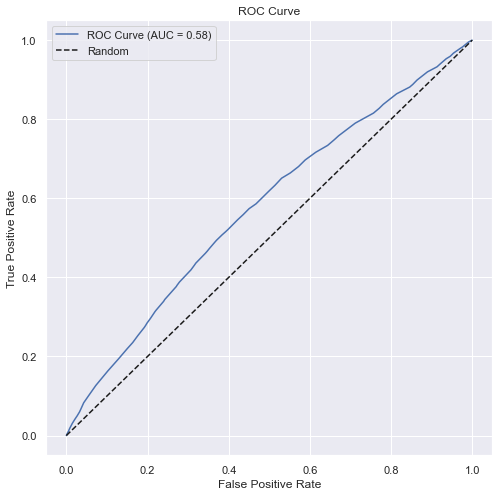

In [35]:
# Calculate AUC of each class
auc_scores = []
for i in range(model.classes_.shape[0]):
    auc_score = roc_auc_score(y_test == model.classes_[i], predictions[:, i])
    auc_scores.append(auc_score)

# Print AUC scores for each class
for i, auc_score in enumerate(auc_scores):
    print(f"Class {model.classes_[i]} AUC: {auc_score}")

fpr, tpr, thresholds = roc_curve(y_test == model.classes_[0], predictions[:, 0])

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_scores[0]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

The model is slightly better than a random prediction.

In [47]:
y_test_bin = label_binarize(y_test, classes=model.classes_)
model = OneVsRestClassifier(LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=1500))
model.fit(X_train, y_train)
y_score = model.decision_function(X_test)

/Users/emilychen/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/emilychen/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/emilychen/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/emilychen/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype

/Users/emilychen/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/emilychen/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/emilychen/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/emilychen/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future

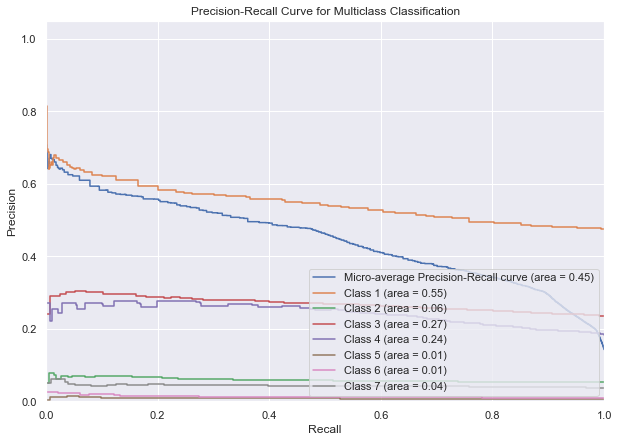

In [49]:
# precision recall curve

precision = dict()
recall = dict()
average_precision = dict()

for i in range(len(model.classes_)):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i],y_score[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])
    
    
    
#Compute micro-average precision-recall curve and area under the curve
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_bin.ravel(), y_score.ravel())
average_precision["micro"] = average_precision_score(y_test_bin, y_score, average="micro")

# Plot the precision-recall curve for each class
plt.figure(figsize=(10, 7))
plt.step(recall['micro'], precision['micro'], where='post', label='Micro-average Precision-Recall curve (area = {0:0.2f})'.format(average_precision["micro"]))
for i in range(len(model.classes_)):
    plt.step(recall[i], precision[i], where='post', label='Class {0} (area = {1:0.2f})'.format(i+1, average_precision[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()
